Purpose of this notebook is do feature extraction / feature engineering on the results from multi-point tracking of the amphioxus larvae using DLC software.
The aims include :
1. Examine the quality of the results obtained from DLC
2. Calculate features from the data which can meaningfully describe the locomotion
3. Examine if missing datapoints can be interpolated
4. Make sure any outliers and noisy datapoints are removed

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.append('../../utils/')

In [4]:
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
widgets.__version__

'8.0.6'

In [5]:
import random

In [6]:
from dlc_helper import DLC_tracking
from features import *

# Data

In [7]:
# Which DLC results (videos) are to be taken for further analysis

with open(r'path_to_videos_with_dlc_results_to_calc_speed.txt', 'r') as file:
    list_DLC_filepaths = [line.rstrip() for line in file]
len(list_DLC_filepaths)

500

In [58]:
filepath = list_DLC_filepaths[320]
filename = os.path.basename(filepath)
foldername = os.path.dirname(filepath)
dlc_obj = DLC_tracking(filename, foldername)

In [59]:
filename

'20180724_114144_1_15m0s_None_None_None_INVERTEDDLC_resnet50_AmphioxusJun19shuffle1_110000_el.h5'

In [60]:
dlc_obj.df_data

,frame,NT_x,NT_y,NT_likelihood,EYE_x,EYE_y,EYE_likelihood,DH1_x,DH1_y,DH1_likelihood,...,VNP_x,VNP_y,VNP_likelihood,MOUTH_x,MOUTH_y,MOUTH_likelihood,NTB_x,NTB_y,NTB_likelihood,n_missing_bodyparts
0,0,283.461,828.563,0.999,284.136,829.655,1.000,289.319,820.104,1.000,...,290.699,818.228,0.023,NaN,NaN,0.000,290.200,830.337,0.355,6
1,1,1067.376,684.556,0.078,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,27
2,2,1067.248,684.897,0.060,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,27
3,3,1067.524,684.631,0.059,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,27
4,4,1067.721,684.578,0.057,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26956,26956,324.330,213.370,1.000,330.999,205.413,0.985,331.467,203.684,0.992,...,340.272,195.831,0.281,332.126,204.511,0.111,325.076,212.716,0.546,1
26957,26957,324.575,212.952,1.000,330.471,205.850,0.999,332.022,203.584,1.000,...,341.407,195.519,0.915,332.172,204.531,0.642,324.729,203.958,0.820,0
26958,26958,325.118,212.835,1.000,328.429,207.682,1.000,332.393,205.223,1.000,...,339.532,194.283,0.993,332.428,204.420,0.046,325.999,204.874,0.992,0
26959,26959,324.666,213.307,1.000,329.998,210.122,1.000,331.852,203.813,1.000,...,340.007,196.129,0.378,332.010,204.315,0.257,325.513,211.949,0.325,0


In [61]:
df_data = dlc_obj.df_data
df_data.shape

(26961, 89)

In [62]:
# df_data.filter(regex='_x|_y').min()

# Missing datapoints

<AxesSubplot: >

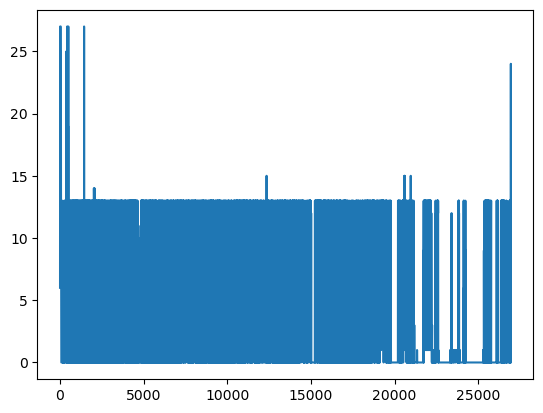

In [63]:
# How many datapoints are missing 
# Have added a variable to the DLC_tracking class that stores the count of missing body parts in each frame for the given DLC results
dlc_obj.df_data.n_missing_bodyparts.plot()

## Missing data: Interpolate 

How do we deal with the missing datapoints?

- Having ~14 bodyparts missing could also indicate that ventral side isnt seen (muscular swimming).
- If all 29 points are missing, either the animal isnt visible in the arena or DLC failed to detect the animal. 
-  Apparently, there are also cases where some dorsal points are not detected.

Thus:

1. We can interpolate across the spatial scale and temporal scale:
   1. Since there is some dependency (assumption based on the animal morphology) between the points on the animal body, we can interpolate on the 2d space.
   2. Since location of a point cannot be totally independent across time, we can also interpolate on the temporal axis
2. On the spatial axis, it makes sense to use interpolation techniques independently on the dorsal and ventral points independently. This is because it would be easier to assume that each of the dorsal and ventral sides are two smooth (biological/ morphological constraints) curves.

In [64]:
def interpol_spatial(df, method='pchip', limit=2):
    col_dict = {col: i for i, col in enumerate(df.columns)}
    col_dict_rev = {v:k for k,v in col_dict.items()}
    # assuming dorsal or ventral side to be a cubic-spline 
    df_interp = df.rename(columns=col_dict).interpolate(axis=1, method=method, limit=limit,limit_area='inside').rename(columns=col_dict_rev)
    return df_interp

def interpol_temporal(df, limit=5, direction='both'):
    df_interp = df.interpolate(limit=limit, limit_direction=direction)
    return df_interp

Treating dorsal and ventral points independently makes life easier. 
Also, 
- I am going to not consider frames where I have less than 7 dorsal points to work with. That is too few to get a decent interpolation.
- Also, for those frames where more than half (5) of the ventral points are missing, it will be assumed that ventral points arent visible. This is to ensure that the interpolation doesnt throw error.

**TODO : Check if adding an exception to interpolation and keeping the ventral points even if less than 5 (not interpolating) is a better idea. This can be especially useful if speed is not going to be considered for ventral points. Just using visibility can be a way to cirucumvent this situation or even having to interpolate altogether.. !!!!**

In [65]:
df_dorsal = df_data.filter(regex='^(NT_|TT_|D).*(x|y)$')
df_dorsal_filt = df_dorsal[df_dorsal.isna().sum(axis=1) < 5]
df_dorsal_x = df_dorsal_filt.filter(like='_x')
df_dorsal_y = df_dorsal_filt.filter(like='_y')
df_dorsal_interp_x = interpol_spatial(df_dorsal_x)
df_dorsal_interp_y = interpol_spatial(df_dorsal_y)

In [66]:
df_ventral = df_data.filter(regex='^V.*(x|y)$')
df_ventral_filt = df_ventral[df_ventral.isna().sum(axis=1) < 3]
df_ventral_x = df_ventral_filt.filter(like='_x')
df_ventral_y = df_ventral_filt.filter(like='_y')
df_ventral_interp_x = interpol_spatial(df_ventral_x)
df_ventral_interp_y = interpol_spatial(df_ventral_y)

In [67]:
df_dorsal_x_fin = interpol_temporal(df_dorsal_interp_x)
df_dorsal_y_fin = interpol_temporal(df_dorsal_interp_y)
df_ventral_x_fin = interpol_temporal(df_ventral_interp_x)
df_ventral_y_fin = interpol_temporal(df_ventral_interp_y)

In [68]:
len(df_dorsal_x_fin.index), len(df_dorsal_y_fin.index), len(df_ventral_x_fin.index), len(df_ventral_y_fin.index)

(26898, 26898, 18718, 18718)

In [69]:
df_dorsal_fin = df_dorsal_x_fin.join(df_dorsal_y_fin)[df_dorsal.columns]
df_ventral_fin = df_ventral_x_fin.join(df_ventral_y_fin)[df_ventral.columns]
df_fin = df_dorsal_fin.join(df_ventral_fin)
print(len(df_fin.index))

26898


In [34]:
dorsal_xy_vals = df_dorsal_fin.values.reshape((-1,15,2))
dorsal_xy_vals.shape

(8828, 15, 2)

In [35]:
ventral_xy_vals = df_ventral_fin.values.reshape((-1,11,2))
ventral_xy_vals.shape

(507, 11, 2)

In [36]:
# df_ventral_fin.isna().sum()

# Features

## Length

In [353]:
skel_lengths = get_length(dorsal_xy_vals)
skel_lengths.shape

(26792,)

In [354]:
skel_lengths_ppsum = get_length(dorsal_xy_vals, len_type='sum_point_to_point')
skel_lengths_ppsum.shape

(26792,)

In [355]:
skel_lengths_ppavg = get_length(dorsal_xy_vals, len_type='mean_point_to_point')
skel_lengths_ppavg.shape

(26792,)

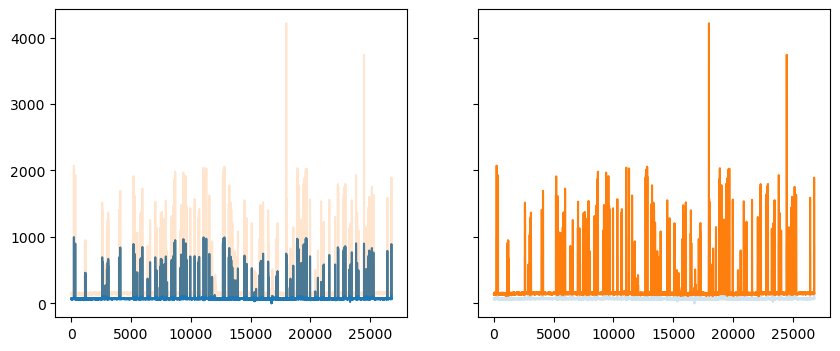

In [356]:
fig, axes = plt.subplots(1,2,figsize=(10,4), sharey=True)
axes[0].plot(skel_lengths)
axes[0].plot(skel_lengths_ppsum, alpha=0.2)
axes[1].plot(skel_lengths, alpha = 0.2)
axes[1].plot(skel_lengths_ppsum)
plt.show()

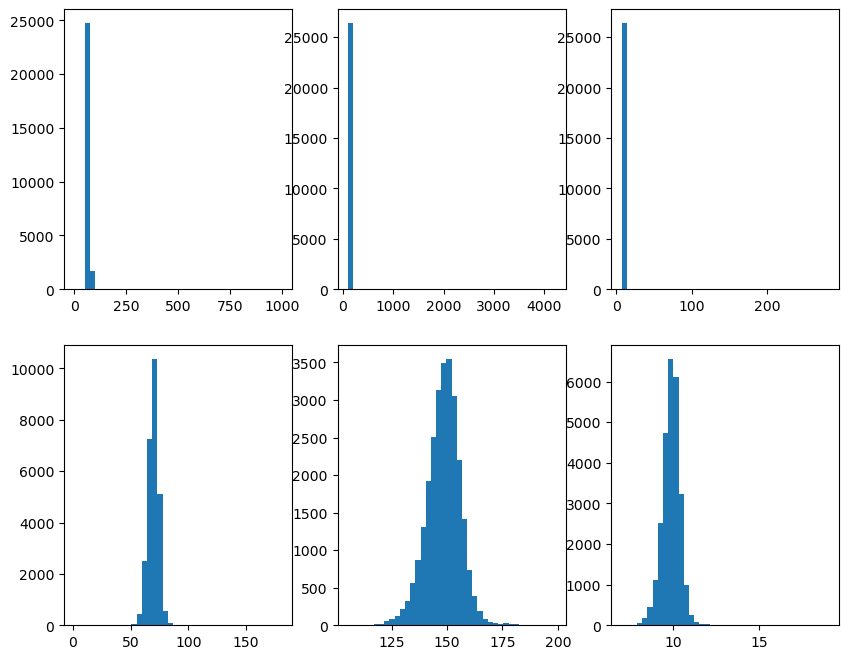

In [357]:
fig, axes = plt.subplots(2,3,figsize=(10,8))
axes = axes.ravel()
axes[0].hist(skel_lengths, bins=40)
axes[1].hist(skel_lengths_ppsum, bins=40)
axes[2].hist(skel_lengths_ppavg, bins=40)

axes[3].hist(skel_lengths[skel_lengths <200], bins=40)
axes[4].hist(skel_lengths_ppsum[skel_lengths_ppsum < 200], bins=40)
axes[5].hist(skel_lengths_ppavg[skel_lengths_ppavg < 20], bins=40)
plt.show()

In [358]:
np.corrcoef(skel_lengths, skel_lengths_ppavg)

array([[1.        , 0.97674253],
       [0.97674253, 1.        ]])

In [359]:
np.corrcoef(skel_lengths, skel_lengths_ppsum)

array([[1.        , 0.97674253],
       [0.97674253, 1.        ]])

### Debugging 

In [360]:
long_skels = list(dorsal_xy_vals[skel_lengths > 120,:,:])
print(len(long_skels), long_skels[0].shape)

289 (15, 2)


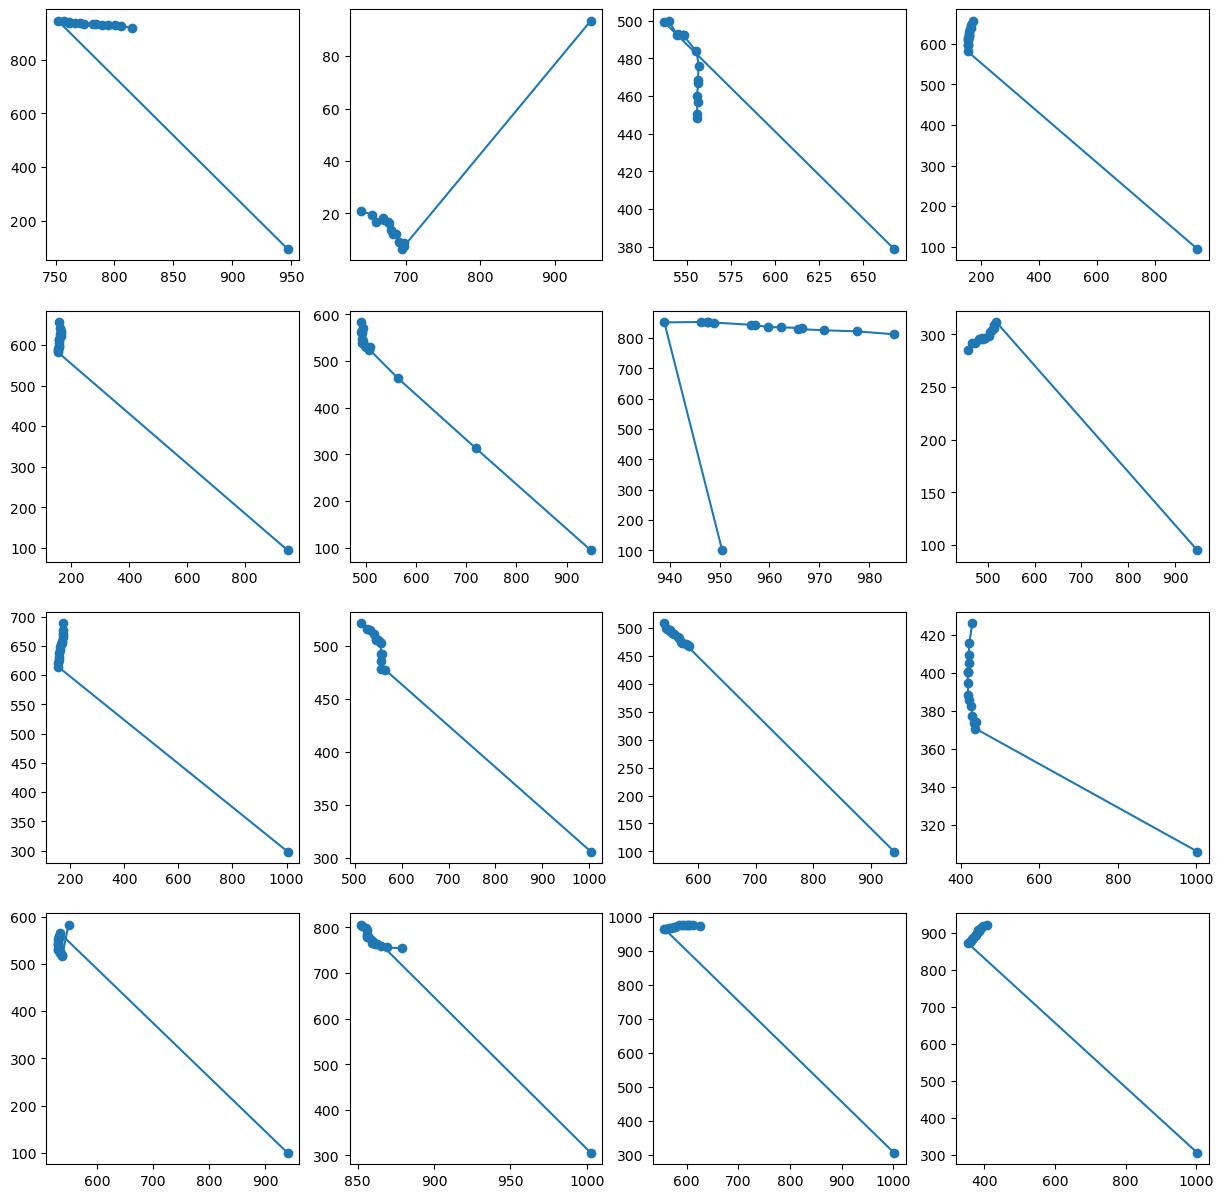

In [361]:
sample_long_skels = random.sample((long_skels), 16)
fig, axes = plt.subplots(4,4,figsize=(15,15))
axes = np.ravel(axes)
for i, skel in enumerate(sample_long_skels):
    axes[i].scatter(skel[:,0], skel[:,1])
    axes[i].plot(skel[:,0], skel[:,1])

In [362]:
short_skels = list(dorsal_xy_vals[skel_lengths < 20,:,:])
print(len(short_skels), short_skels[0].shape)

2 (15, 2)


In [363]:
sample_short_skels = random.sample((short_skels), 16)
fig, axes = plt.subplots(4,4,figsize=(15,15))
axes = np.ravel(axes)
for i, skel in enumerate(sample_short_skels):
    axes[i].scatter(skel[:,0], skel[:,1])
    axes[i].plot(skel[:,0], skel[:,1])

ValueError: Sample larger than population or is negative

In [364]:
long_pp_skels = list(dorsal_xy_vals[skel_lengths_ppsum > 200,:,:])
print(len(long_pp_skels))

342


In [365]:
short_pp_skels = list(dorsal_xy_vals[skel_lengths_ppsum < 20,:,:])
print(len(short_pp_skels))

0


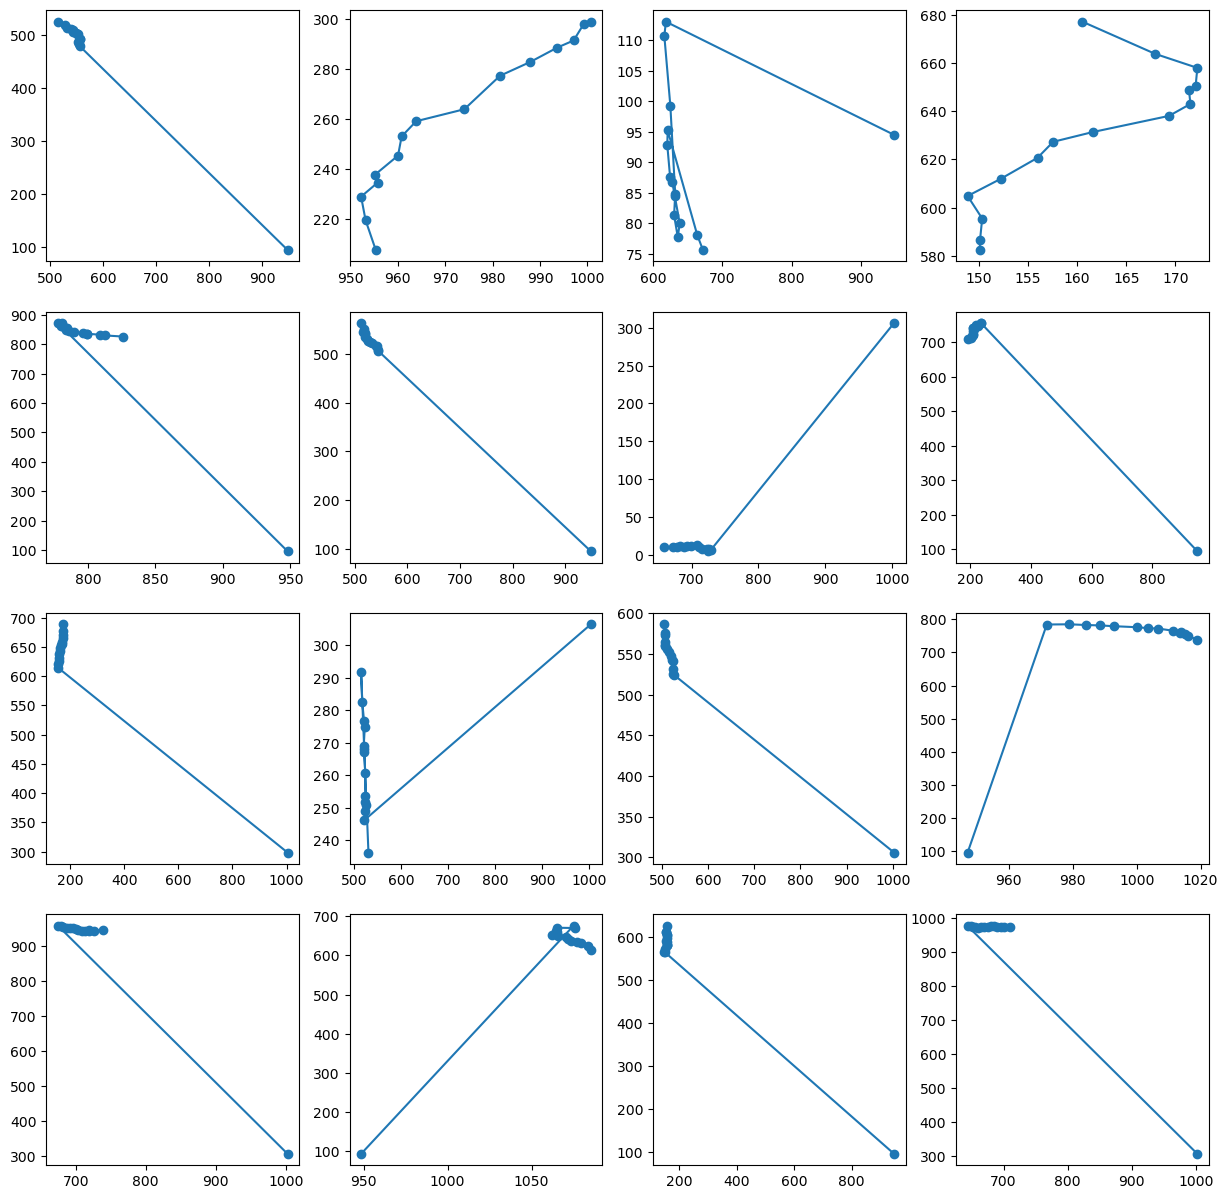

In [366]:
sample_long_pp_skels = random.sample((long_pp_skels), 16)
fig, axes = plt.subplots(4,4,figsize=(15,15))
axes = np.ravel(axes)
for i, skel in enumerate(sample_long_pp_skels):
    axes[i].scatter(skel[:,0], skel[:,1])
    axes[i].plot(skel[:,0], skel[:,1])

### Pick only frames which have sensible lengths 

The challenge here is to drop the frames which severely erroneous tracking without letting go those which have one odd outlier bodypart !  

For now, we remove any frame which has too long or too short "skeleton" length

In [367]:
df_dorsal_fin.shape

(26792, 30)

In [368]:
df_skel_lengths = pd.DataFrame(index= df_dorsal_fin.index, columns=['NT_to_TT', 'sum_of_parts', 'mean_of_parts'])
df_skel_lengths['NT_to_TT'] = list(skel_lengths)
df_skel_lengths['sum_of_parts'] = list(skel_lengths_ppsum)
df_skel_lengths['mean_of_parts'] = list(skel_lengths_ppavg)
df_skel_lengths

,NT_to_TT,sum_of_parts,mean_of_parts
0,63.106194,139.256721,9.283781
1,66.097439,136.290980,9.086065
2,64.246994,130.793395,8.719560
3,71.411675,144.838130,9.655875
4,69.582299,149.097513,9.939834
...,...,...,...
26788,65.162640,145.043933,9.669596
26789,71.070664,154.177347,10.278490
26790,76.258803,160.127921,10.675195
26791,67.271267,145.274851,9.684990


In [369]:
df_skel_lengths_wo_outlier = df_skel_lengths[(df_skel_lengths['NT_to_TT'] > 20) & (df_skel_lengths['NT_to_TT'] < 120) & (df_skel_lengths['sum_of_parts'] < 200)]
df_skel_lengths_wo_outlier

,NT_to_TT,sum_of_parts,mean_of_parts
0,63.106194,139.256721,9.283781
1,66.097439,136.290980,9.086065
2,64.246994,130.793395,8.719560
3,71.411675,144.838130,9.655875
4,69.582299,149.097513,9.939834
...,...,...,...
26788,65.162640,145.043933,9.669596
26789,71.070664,154.177347,10.278490
26790,76.258803,160.127921,10.675195
26791,67.271267,145.274851,9.684990


## Curvatures

### Dorsal side

In [370]:
curv_vals = get_curv_savgol(dorsal_xy_vals, wl=9)
curv_vals.shape

(26792, 15)

In [371]:
df_curv = pd.DataFrame(curv_vals, columns=[f'curv_{x.split("_")[0]}' for x in df_dorsal_x.columns])
df_curv.shape

(26792, 15)

#### Remove outliers

In [372]:
def remove_outliers_IQR(df, col):
    Q1, Q3 = df[col].quantile([.25, .75])
    IQR = Q3 - Q1

    global outlier_free_list 
    global df_curv_wo_outliers

    outlier_free_list = [x for x in df[col] if ((x > (Q1 - 1.5 * IQR)) & (x < (Q3 + 1.5 * IQR)))]
    df_curv_wo_outliers = df.loc[df[col].isin(outlier_free_list)]

For each of the columns in the curvature dataframe, keep only non-outlier (IQR based) points
This would mean that there is a recursive removal of rows/frames such that if any one bodypart has a weird curvature, 
the entire frame is removed. **NOTE: This is convienent, but may not be ideal.**

In [373]:
for i in df_curv.columns:
    if i == df_curv.columns[0]:
        remove_outliers_IQR(df_curv, i)
    else:
        remove_outliers_IQR(df_curv_wo_outliers, i)
        
print(df_curv.shape, df_curv_wo_outliers.shape)

(26792, 15) (24580, 15)


### Correlation of curvatures - dorsal

<AxesSubplot: >

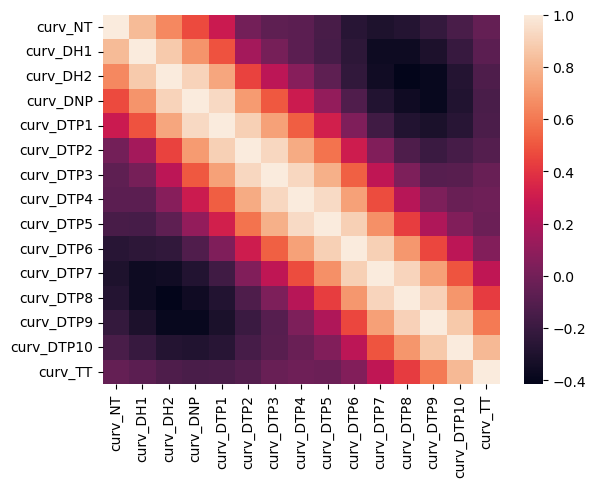

In [374]:
# How correlated are the curvatures of each of the "body parts" 
sns.heatmap(df_curv_wo_outliers.corr())

Of course, now the no-outlier dataset looks like the dorsal points are very much correlated. 
What can we do:
1. Examine how diff is this corr matrix in comparison to Ciona?
2. Can compute eigen / PCA - amphi although we dont have the ventral data points
3. Can also look at the curvatures of ventral side independently 

### Ventral side

In [375]:
curv_vals_ventral = get_curv_savgol(ventral_xy_vals, wl=9)
curv_vals_ventral.shape

(12415, 11)

In [376]:
df_curv_ventral = pd.DataFrame(curv_vals_ventral, columns=[f'curv_{x.split("_")[0]}' for x in df_ventral_x.columns])
df_curv_ventral.shape

(12415, 11)

In [377]:
def remove_outliers_IQR_ventral(df, col):
    Q1, Q3 = df[col].quantile([.25, .75])
    IQR = Q3 - Q1

    global outlier_free_list_ventral
    global df_curv_ventral_wo_outliers

    outlier_free_list_ventral = [x for x in df[col] if ((x > (Q1 - 1.5 * IQR)) & (x < (Q3 + 1.5 * IQR)))]
    df_curv_ventral_wo_outliers = df.loc[df[col].isin(outlier_free_list_ventral)]

In [378]:
for i in df_curv_ventral.columns:
    if i == df_curv_ventral.columns[0]:
        remove_outliers_IQR_ventral(df_curv_ventral, i)
    else:
        remove_outliers_IQR_ventral(df_curv_ventral_wo_outliers, i)
        
print(df_curv_ventral.shape, df_curv_ventral_wo_outliers.shape)

(12415, 11) (10990, 11)


<AxesSubplot: >

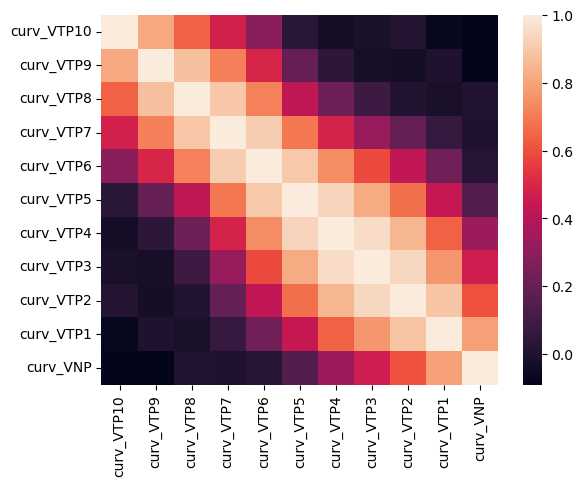

In [379]:
sns.heatmap(df_curv_ventral_wo_outliers.corr())

In [380]:
df_curv_wo_outliers_fin = df_skel_lengths_wo_outlier.join(df_curv_wo_outliers, how='inner')
df_curv_wo_outliers_fin

,NT_to_TT,sum_of_parts,mean_of_parts,curv_NT,curv_DH1,curv_DH2,curv_DNP,curv_DTP1,curv_DTP2,curv_DTP3,curv_DTP4,curv_DTP5,curv_DTP6,curv_DTP7,curv_DTP8,curv_DTP9,curv_DTP10,curv_TT
0,63.106194,139.256721,9.283781,0.002122,0.011545,0.013281,0.017190,0.024551,0.026884,0.027237,0.038957,0.027395,0.021226,0.015894,0.009987,0.002066,0.001860,0.028677
1,66.097439,136.290980,9.086065,-0.013090,-0.005965,0.007619,0.016560,0.018175,0.020500,0.011846,0.003950,-0.000112,0.008548,0.019110,0.017599,0.007673,0.006798,0.006754
2,64.246994,130.793395,8.719560,-0.001963,-0.002772,0.000212,0.000821,0.000545,-0.002009,-0.001843,-0.002461,-0.002488,-0.005219,-0.004633,-0.008048,-0.012843,-0.020420,-0.009199
3,71.411675,144.838130,9.655875,-0.000177,0.000620,0.003269,0.005685,0.008202,0.006882,0.006586,0.005107,0.008299,0.004047,0.003538,0.000192,-0.008319,-0.025976,-0.011921
4,69.582299,149.097513,9.939834,-0.000838,0.000677,0.011873,0.020186,0.037300,0.026290,0.023130,0.013280,0.008587,0.001190,-0.001295,-0.006955,-0.000341,-0.017216,-0.012899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26787,65.710789,143.199669,9.546645,0.007033,0.013788,0.019713,0.032386,0.051155,0.052521,0.049409,0.029517,0.023063,0.009963,0.004444,-0.002468,-0.002702,-0.006661,-0.007184
26788,65.162640,145.043933,9.669596,-0.003542,-0.009840,-0.005542,-0.007834,0.002836,0.017902,0.026000,0.030238,0.040647,0.027915,0.025379,0.014765,0.011105,0.000562,0.002807
26789,71.070664,154.177347,10.278490,-0.002381,-0.003758,-0.009304,-0.021931,-0.033637,-0.028797,-0.027061,-0.020615,-0.012967,0.004075,0.013318,0.023220,0.028338,0.036042,0.021186
26790,76.258803,160.127921,10.675195,0.007377,0.014945,0.013839,0.011421,-0.002392,-0.031230,-0.049029,-0.059012,-0.051501,-0.024460,-0.019065,-0.007431,0.000380,-0.001359,-0.003126


How are the dorsal curvatures and ventral side curvatures correlated. 

Hypothesis: When ventral side is seen, these sides should be correlated ! 

In [381]:
df_curv_joined = df_curv_wo_outliers_fin.join(df_curv_ventral_wo_outliers, how='inner')
df_curv_joined

,NT_to_TT,sum_of_parts,mean_of_parts,curv_NT,curv_DH1,curv_DH2,curv_DNP,curv_DTP1,curv_DTP2,curv_DTP3,...,curv_VTP9,curv_VTP8,curv_VTP7,curv_VTP6,curv_VTP5,curv_VTP4,curv_VTP3,curv_VTP2,curv_VTP1,curv_VNP
0,63.106194,139.256721,9.283781,0.002122,0.011545,0.013281,0.017190,0.024551,0.026884,0.027237,...,-0.003768,-0.009309,-0.006867,-0.005427,-0.005693,-0.002893,-0.004556,-0.007519,-0.003662,-0.018856
1,66.097439,136.290980,9.086065,-0.013090,-0.005965,0.007619,0.016560,0.018175,0.020500,0.011846,...,0.000843,0.005251,-0.000134,-0.002792,-0.007707,-0.011586,-0.013609,-0.009404,0.006825,0.017346
2,64.246994,130.793395,8.719560,-0.001963,-0.002772,0.000212,0.000821,0.000545,-0.002009,-0.001843,...,0.010246,0.008152,0.008018,0.011414,0.005530,0.004838,0.002510,-0.001004,-0.002582,-0.005957
4,69.582299,149.097513,9.939834,-0.000838,0.000677,0.011873,0.020186,0.037300,0.026290,0.023130,...,-0.013944,-0.019926,-0.023026,-0.027349,-0.022979,-0.016800,-0.007732,-0.013464,-0.018409,-0.022287
5,63.439964,136.046942,9.069796,-0.020021,-0.013732,0.000434,0.014776,0.030730,0.035053,0.014543,...,-0.003647,0.003371,0.000153,-0.000940,0.002327,0.007169,0.008070,0.011513,0.014764,0.025863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12409,72.286681,153.990898,10.266060,0.002129,-0.002523,-0.015563,-0.025501,-0.030599,-0.039838,-0.033641,...,0.012726,0.002207,-0.003096,-0.020581,-0.031089,-0.036857,-0.038639,-0.035505,-0.023108,-0.008888
12410,70.236087,149.905834,9.993722,-0.006262,-0.008029,-0.005592,-0.006678,-0.003610,-0.003705,-0.008707,...,-0.042067,-0.031933,-0.027831,-0.023756,-0.011015,0.001414,0.004966,0.007849,0.015116,0.029397
12411,73.998531,154.984108,10.332274,-0.002894,0.005905,0.013458,0.020150,0.028420,0.037315,0.032661,...,0.012188,0.020689,0.016669,0.011587,0.012438,0.008777,0.001659,0.002813,0.021201,0.040089
12412,67.082155,142.631454,9.508764,-0.001256,-0.002823,-0.000658,-0.000472,0.006180,0.012195,0.029428,...,-0.015531,-0.018210,-0.018823,-0.018647,-0.014921,-0.014394,-0.016235,-0.014215,-0.010987,-0.018061


In [382]:
result = df_curv_joined.corr()
corr_dorsal_ventral = result.loc[df_curv_wo_outliers.columns, df_curv_ventral.columns]
corr_dorsal_ventral

,curv_VTP10,curv_VTP9,curv_VTP8,curv_VTP7,curv_VTP6,curv_VTP5,curv_VTP4,curv_VTP3,curv_VTP2,curv_VTP1,curv_VNP
curv_NT,0.008609,0.017094,0.011942,0.010456,0.008629,0.006175,0.003993,0.003808,0.005995,0.007837,-0.001745
curv_DH1,0.008519,0.015881,0.009777,0.006861,0.005212,0.002414,0.004427,0.005945,0.009777,0.016057,0.008227
curv_DH2,0.007007,0.018752,0.011385,0.009121,0.007637,0.001857,0.001261,0.000315,0.000610,0.009066,0.002095
curv_DNP,0.009820,0.018884,0.012262,0.009713,0.007824,-0.000048,-0.003529,-0.005267,-0.006618,0.000195,-0.002878
curv_DTP1,0.007433,0.012721,0.006665,0.005982,0.004354,-0.002617,-0.008205,-0.010873,-0.013012,-0.008493,-0.009332
curv_DTP2,0.001543,0.002308,-0.000433,0.000122,0.000039,-0.005364,-0.012495,-0.016187,-0.019313,-0.017918,-0.014138
curv_DTP3,-0.007242,-0.009421,-0.008589,-0.007302,-0.005375,-0.007413,-0.014900,-0.019603,-0.023148,-0.024676,-0.017616
curv_DTP4,-0.013050,-0.018322,-0.015598,-0.013120,-0.009869,-0.008239,-0.013682,-0.017463,-0.019739,-0.023313,-0.015322
curv_DTP5,-0.012331,-0.021959,-0.019712,-0.017456,-0.013757,-0.008912,-0.011130,-0.012885,-0.012624,-0.016712,-0.009835
curv_DTP6,-0.012520,-0.023331,-0.020015,-0.019875,-0.017454,-0.011396,-0.009633,-0.010075,-0.008913,-0.012787,-0.005076


<AxesSubplot: >

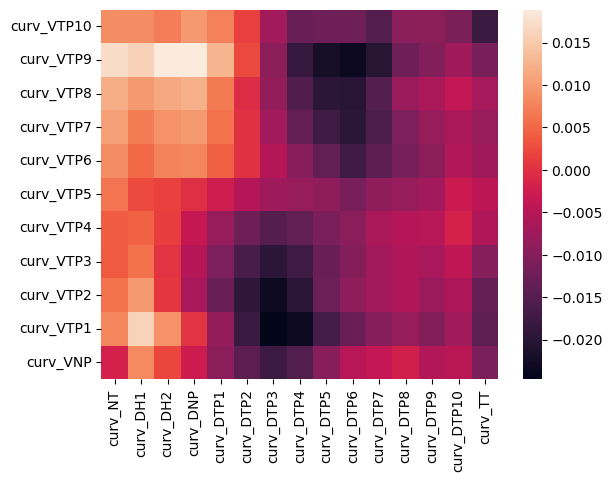

In [383]:
sns.heatmap(corr_dorsal_ventral.T)

**Wondering : The correlation values are quite low. Weakly correlated ! Does that mean, the pattern isnt significant?**

#### Some stats

In [384]:
df_curv_joined.columns

Index(['NT_to_TT', 'sum_of_parts', 'mean_of_parts', 'curv_NT', 'curv_DH1',
       'curv_DH2', 'curv_DNP', 'curv_DTP1', 'curv_DTP2', 'curv_DTP3',
       'curv_DTP4', 'curv_DTP5', 'curv_DTP6', 'curv_DTP7', 'curv_DTP8',
       'curv_DTP9', 'curv_DTP10', 'curv_TT', 'curv_VTP10', 'curv_VTP9',
       'curv_VTP8', 'curv_VTP7', 'curv_VTP6', 'curv_VTP5', 'curv_VTP4',
       'curv_VTP3', 'curv_VTP2', 'curv_VTP1', 'curv_VNP'],
      dtype='object')

<AxesSubplot: ylabel='curv_DTP4'>

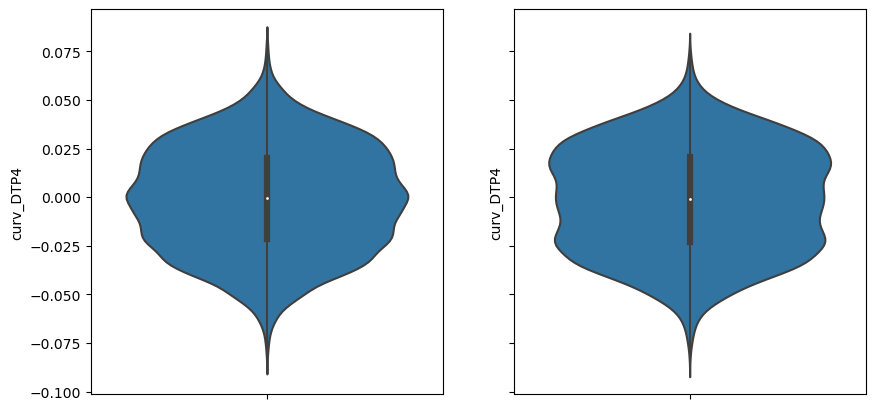

In [385]:
fig, axes1 = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.violinplot(df_curv_wo_outliers, y= 'curv_DTP4', ax = axes1[0])
sns.violinplot(df_curv_joined, y='curv_DTP4', ax=axes1[1])

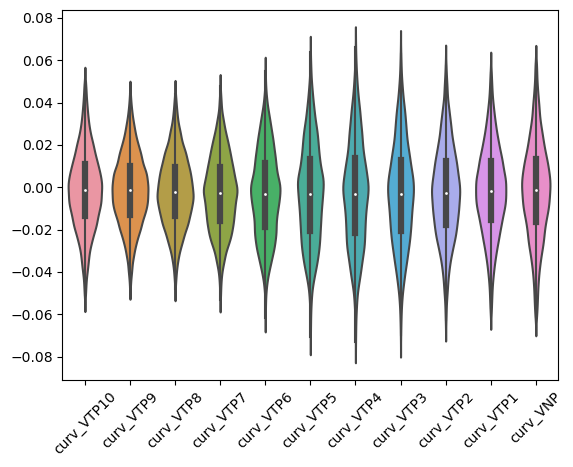

In [386]:
sns.violinplot(data=df_curv_ventral_wo_outliers.filter(like='curv_'))
plt.xticks(rotation=45)
plt.show()

Afterall, what information does the curvatures of the ventral points give us ?? 

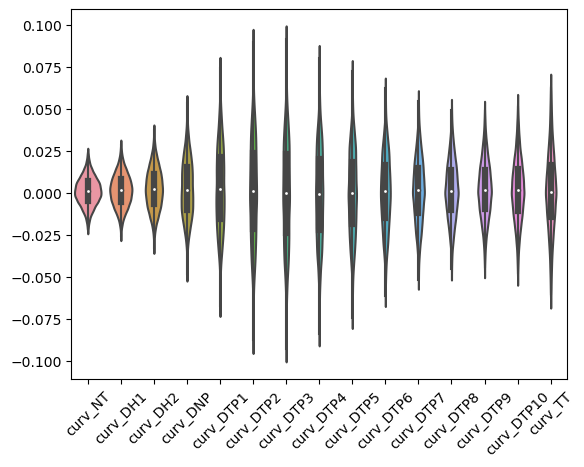

In [387]:
sns.violinplot(data=df_curv_wo_outliers)
plt.xticks(rotation=45)
plt.show()

How sensitive are these curvature calculations to the SAVITZKY-GOLAY filter parameters ! Esp, the window-length !!
**TODO: Make sure the parameters chosen are valid/sensible, ie, they should make valid assumptions only ! 

#### Curvature calculations : Examining the parameters of savgolay filter used

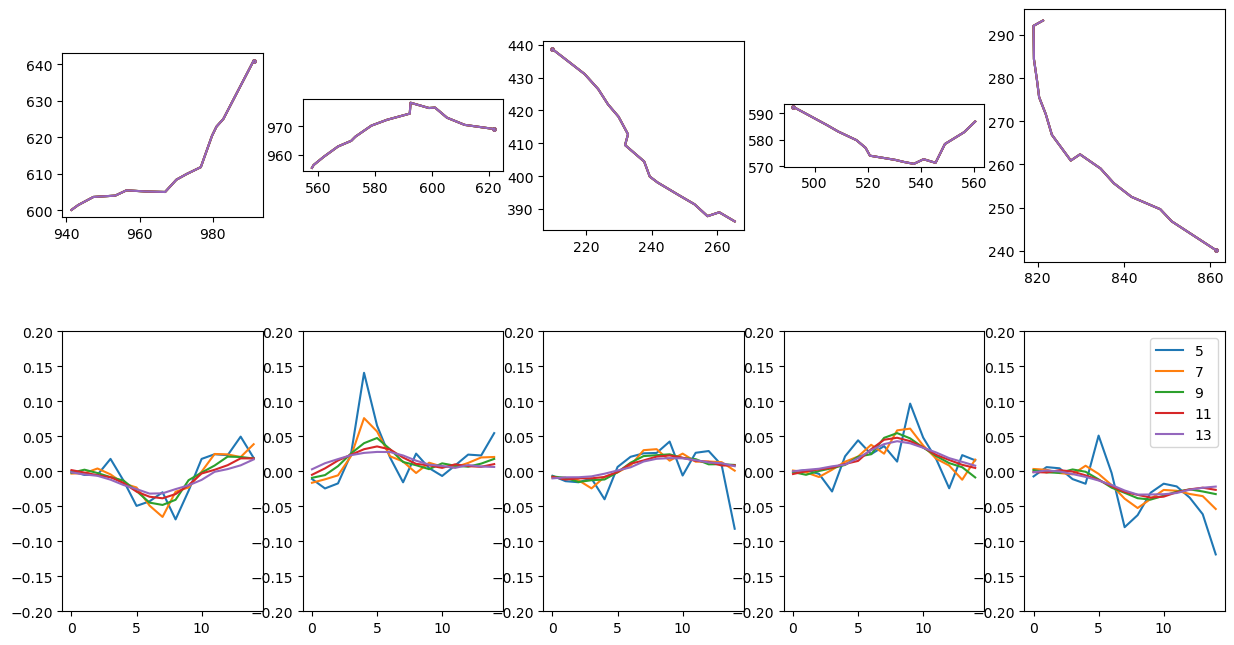

In [388]:
dorsal_idx_samples = random.sample(list(df_curv_wo_outliers.index), 5)


fig1, axes1 = plt.subplots(2,5, figsize=(15,8))
for i, wl in enumerate([5,7,9, 11, 13]):
    for j, d_idx in enumerate(dorsal_idx_samples):
        test_dorsal_curv = get_curv_savgol(dorsal_xy_vals[d_idx, :, :].reshape(1,15,2), wl=wl)
        axes1[1][j].plot(test_dorsal_curv.reshape(15,), label=f'{wl}')
        axes1[1][j].set_ylim([-0.2, 0.2])
        axes1[0][j].plot(dorsal_xy_vals[d_idx,:,0],dorsal_xy_vals[d_idx,:,1])
        axes1[0][j].scatter(dorsal_xy_vals[d_idx,0,0],dorsal_xy_vals[d_idx,0,1], s=5)
        axes1[0][j].set_aspect('equal')
    plt.legend()

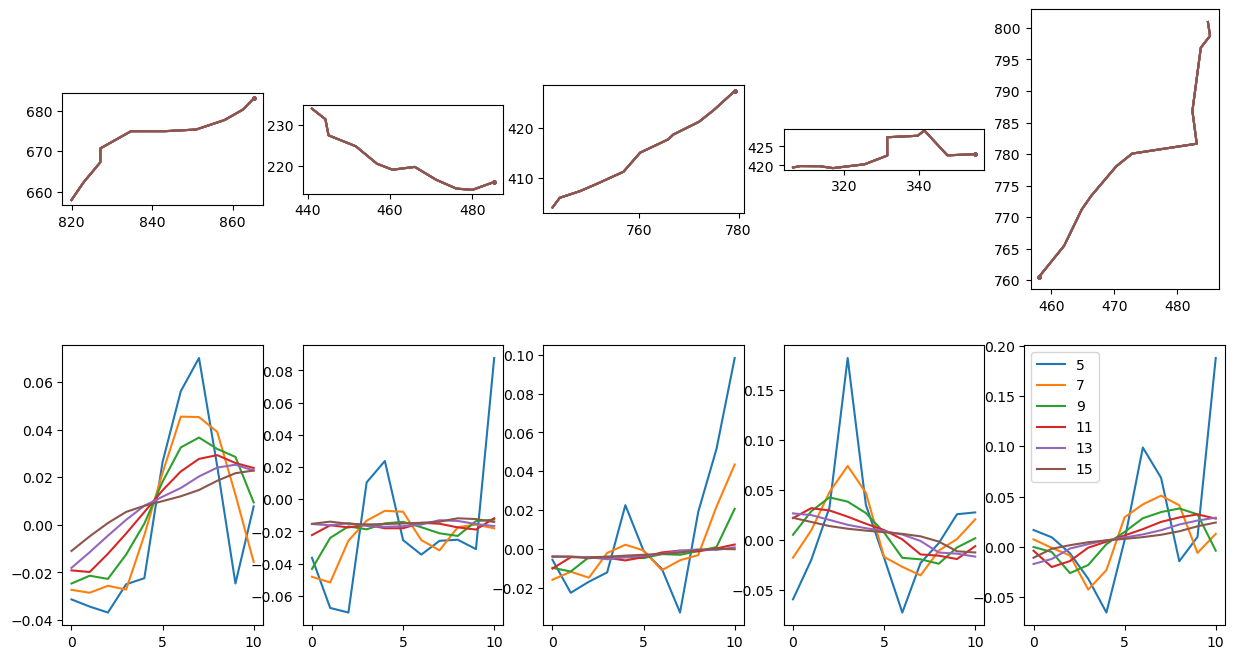

In [389]:
ventral_idx_samples = random.sample(list(df_curv_ventral_wo_outliers.index), 5)

fig2, axes2 = plt.subplots(2,5, figsize=(15,8))
for i, wl in enumerate([5,7,9, 11, 13, 15]):
    for j, v_idx in enumerate(ventral_idx_samples):
        test_ventral_curv = get_curv_savgol(ventral_xy_vals[v_idx, :, :].reshape(1,11,2), wl=wl)
        axes2[1][j].plot(test_ventral_curv.reshape(11,), label=f'{wl}')
        axes2[0][j].plot(ventral_xy_vals[v_idx,:,0],ventral_xy_vals[v_idx,:,1])
        axes2[0][j].scatter(ventral_xy_vals[v_idx,0,0],ventral_xy_vals[v_idx,0,1], s=5)
        axes2[0][j].set_aspect('equal')
    plt.legend()

Maybe these analyses would make more sense when all the data are considered together

In [390]:
# widget_winlen = widgets.IntSlider(min=3, max=9, step=2, value=7)

In [391]:
# @interact_manual
# def check_curvature(wl=widget_winlen, dorsal=True):
#     if dorsal:
#         curv_vals = get_curv_savgol(dorsal_xy_vals, wl=wl)

## Quirkiness

In [392]:
quirkiness = get_quirkiness(dorsal_xy_vals)
df_quirk = pd.DataFrame(quirkiness, columns=['quirkiness'])
df_quirk.shape

(26792, 1)

In [393]:
df_curv_wo_outliers.corrwith(df_quirk.loc[df_curv_wo_outliers.index, 'quirkiness'])

curv_NT      -0.048514
curv_DH1     -0.045223
curv_DH2     -0.052961
curv_DNP     -0.071257
curv_DTP1    -0.093670
curv_DTP2    -0.099026
curv_DTP3    -0.094712
curv_DTP4    -0.087027
curv_DTP5    -0.070159
curv_DTP6    -0.039389
curv_DTP7    -0.007082
curv_DTP8     0.006148
curv_DTP9     0.011506
curv_DTP10    0.005556
curv_TT       0.003827
dtype: float64

In [394]:
df_curv_joined.corrwith(df_quirk.loc[df_curv_joined.index, 'quirkiness'])

NT_to_TT         0.071604
sum_of_parts    -0.003861
mean_of_parts   -0.003861
curv_NT         -0.057183
curv_DH1        -0.042581
curv_DH2        -0.045784
curv_DNP        -0.062077
curv_DTP1       -0.076529
curv_DTP2       -0.072914
curv_DTP3       -0.064723
curv_DTP4       -0.053408
curv_DTP5       -0.035123
curv_DTP6       -0.002106
curv_DTP7        0.022438
curv_DTP8        0.028596
curv_DTP9        0.032866
curv_DTP10       0.016236
curv_TT          0.006319
curv_VTP10      -0.004641
curv_VTP9        0.008355
curv_VTP8        0.014116
curv_VTP7        0.013984
curv_VTP6        0.013088
curv_VTP5        0.006844
curv_VTP4        0.002449
curv_VTP3       -0.006181
curv_VTP2       -0.011113
curv_VTP1       -0.004819
curv_VNP        -0.001188
dtype: float64

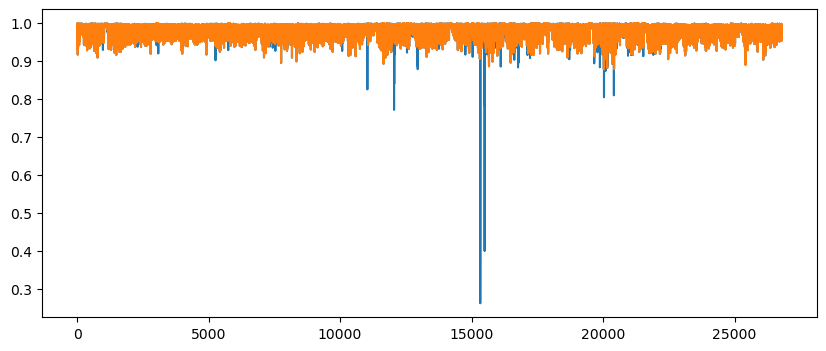

In [395]:
plt.figure(figsize=(10,4))
plt.plot(df_quirk.index, df_quirk['quirkiness'])
plt.plot(df_curv_wo_outliers.index, df_quirk.loc[df_curv_wo_outliers.index, 'quirkiness'])

<AxesSubplot: xlabel='quirkiness'>

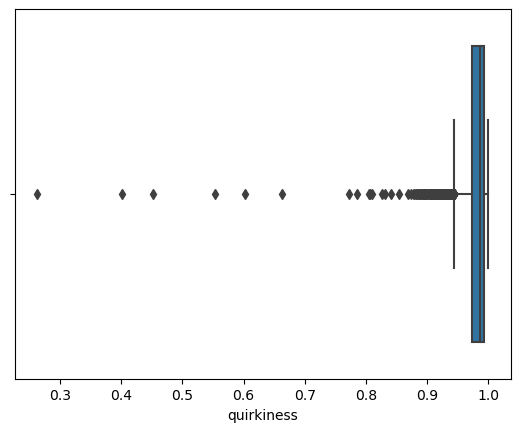

In [396]:
sns.boxplot(df_quirk, x='quirkiness')

# Speeds

In [46]:
def get_speeds(df, filt = False):

    list_bp_speeds = []
    bodyparts = []
    for i, col in enumerate(df.columns):
        bp = col.split('_')[0]
        if bp not in bodyparts:
            bodyparts.append(bp)
            xy_data = df.filter(items = [f'{bp}_x',f'{bp}_y'])
            xy_coords = xy_data.values
            time_indices = xy_data.index
            speeds = calc_speeds(xy_coords, time_indices)
            speeds.name = f'speed_{bp}'
            if filt:
                filt_speeds = filter_speeds(speeds)
                list_bp_speeds.append(filt_speeds)
            else:
                list_bp_speeds.append(speeds)
        
    df_speeds = pd.concat(list_bp_speeds, axis=1)
    return df_speeds


def calc_speeds(bp_xycoords, time_indices):
    diff_xy = np.diff(bp_xycoords, prepend = bp_xycoords[1,:].reshape(1,2), axis=0)
    sum_xy = diff_xy[:,0]**2 + diff_xy[:,1]**2
    sqrt_xy = np.sqrt(sum_xy)
    time_int = np.diff(time_indices, prepend = time_indices[1], axis=0)
    speed = sqrt_xy / time_int
    bp_speed = pd.Series(speed, index=time_indices)
    return bp_speed

def filter_speeds(bp_speed):
    from hampel import hampel
    bp_speed_filt = hampel(bp_speed, window_size=15, n=3, imputation=True)
    # bp_speed_filt.name = f'speed_{bp}'
    return bp_speed_filt

In [75]:
df_dorsal_fin.shape

(26898, 30)

In [79]:
df_dorsal_speeds_unfilt = get_speeds(df_dorsal_fin)
df_dorsal_speeds_unfilt.shape

(26898, 15)

In [77]:
df_dorsal_speeds = get_speeds(df_dorsal_fin.reindex(df_data.index), filt=True)
df_dorsal_speeds.shape

(26961, 15)

In [87]:
df_dorsal_speeds_unfilt['speed_NT'].isna().sum()

0

In [88]:
df_dorsal_speeds.loc[df_dorsal_fin.index, 'speed_NT'].isna().sum()

13

In [86]:
df_dorsal_speeds['speed_NT'].isna().sum()

76

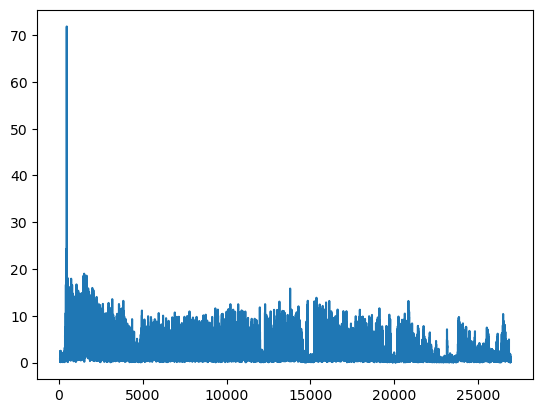

In [89]:
plt.plot(df_dorsal_speeds.loc[df_dorsal_fin.index, 'speed_NT'])

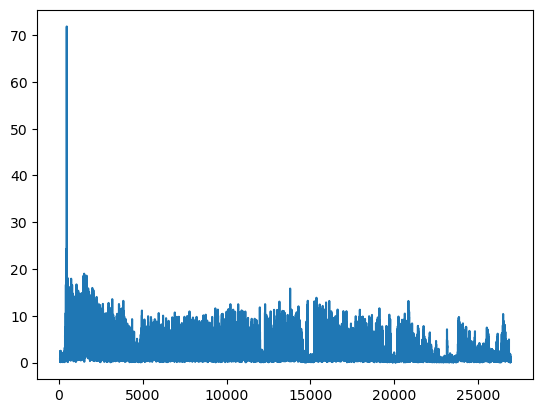

In [82]:
plt.plot(df_dorsal_speeds['speed_NT'])

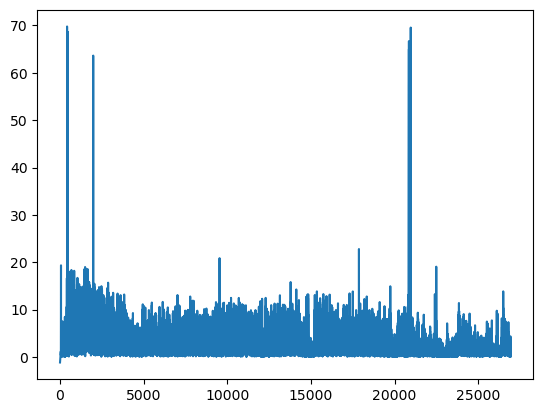

In [85]:

plt.plot(df_dorsal_speeds_unfilt[df_dorsal_speeds_unfilt['speed_NT'] < 70]['speed_NT'])

In [ ]:
sns.heatmap(df_dorsal_speeds.corr())

In [ ]:
sns.boxplot(data=df_dorsal_speeds)
plt.xticks(rotation=45)
plt.show()

In [350]:
# dorsal_xy_vals = df_dorsal_fin.values.reshape((-1,15,2))
# dorsal_xy_vals.shape

(26792, 15, 2)

In [42]:
df_dorsal_fin.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858],
      dtype='int64', length=8828)

In [41]:
df_dorsal_fin.shape

(8828, 30)

### Speeds: ventral

In [70]:
len(df_ventral_fin.index)

18718

In [71]:
df_ventral_fin.index

Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,    78,
       ...
       26949, 26950, 26951, 26952, 26953, 26954, 26956, 26957, 26958, 26959],
      dtype='int64', length=18718)

In [98]:
df_ventral_fin

,VTP10_x,VTP10_y,VTP9_x,VTP9_y,VTP8_x,VTP8_y,VTP7_x,VTP7_y,VTP6_x,VTP6_y,...,VTP4_x,VTP4_y,VTP3_x,VTP3_y,VTP2_x,VTP2_y,VTP1_x,VTP1_y,VNP_x,VNP_y
69,307.421,802.584,300.6760,800.738000,301.207,796.291,291.810,795.984,290.239,788.234,...,289.269,788.325,291.315,785.212,291.414,778.327,284.885,778.015,283.148,778.259
70,307.462,802.602,300.5360,800.821000,301.114,796.343,291.832,795.908,289.953,788.265,...,289.556,788.372,290.763,780.179,284.303,779.323,284.859,777.897,283.209,778.391
71,306.836,802.229,301.5930,796.759000,301.077,795.572,300.109,789.589,291.130,788.977,...,290.206,786.681,291.128,780.860,291.566,778.423,290.879,778.122,283.357,777.550
72,306.516,801.503,302.6080,797.267000,302.494,794.915,299.980,792.804,292.829,789.445,...,290.154,785.838,291.092,781.109,290.934,777.804,285.699,778.004,283.860,776.736
73,307.119,802.246,301.9370,796.697000,301.620,794.629,300.293,789.425,291.998,789.384,...,289.817,786.197,290.701,780.624,285.249,779.640,285.064,777.453,283.153,776.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26954,385.574,165.070,378.3950,171.424000,372.947,171.458,371.016,173.403,363.564,179.304,...,355.696,187.973,355.448,188.678,346.926,188.364,338.947,194.232,339.845,195.413
26956,379.894,157.006,374.9177,172.936349,372.175,179.802,371.275,180.160,363.402,179.633,...,355.725,187.990,355.323,188.153,347.139,189.073,339.891,187.483,340.272,195.831
26957,379.686,165.765,378.8020,171.898000,371.880,172.272,370.339,179.760,363.689,179.436,...,355.556,187.930,354.720,187.949,346.555,189.284,340.421,193.441,341.407,195.519
26958,378.921,165.301,372.8060,167.170000,370.735,172.245,365.740,178.412,363.590,178.640,...,355.313,181.122,347.198,188.382,345.653,189.689,340.147,189.576,339.532,194.283


In [100]:
df_ventral_fin.reindex(df_data.index)

,VTP10_x,VTP10_y,VTP9_x,VTP9_y,VTP8_x,VTP8_y,VTP7_x,VTP7_y,VTP6_x,VTP6_y,...,VTP4_x,VTP4_y,VTP3_x,VTP3_y,VTP2_x,VTP2_y,VTP1_x,VTP1_y,VNP_x,VNP_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26956,379.894,157.006,374.9177,172.936349,372.175,179.802,371.275,180.160,363.402,179.633,...,355.725,187.990,355.323,188.153,347.139,189.073,339.891,187.483,340.272,195.831
26957,379.686,165.765,378.8020,171.898000,371.880,172.272,370.339,179.760,363.689,179.436,...,355.556,187.930,354.720,187.949,346.555,189.284,340.421,193.441,341.407,195.519
26958,378.921,165.301,372.8060,167.170000,370.735,172.245,365.740,178.412,363.590,178.640,...,355.313,181.122,347.198,188.382,345.653,189.689,340.147,189.576,339.532,194.283
26959,379.656,165.619,378.6340,172.303000,371.626,172.835,370.388,179.929,364.064,179.292,...,355.250,187.623,355.277,187.889,346.450,189.396,339.764,194.081,340.007,196.129


In [90]:
df_ventral_speeds_filt =  get_speeds(df_ventral_fin.reindex(df_data.index), filt=True)
df_ventral_speeds_filt.index

RangeIndex(start=0, stop=26961, step=1)

In [94]:
df_ventral_speeds_filt.loc[df_ventral_fin.index, 'speed_VTP10'].isna().sum()

1981

In [91]:
df_ventral_speeds_filt.isna().sum()

speed_VTP10    10224
speed_VTP9     10224
speed_VTP8     10224
speed_VTP7     10224
speed_VTP6     10224
speed_VTP5     10224
speed_VTP4     10224
speed_VTP3     10224
speed_VTP2     10224
speed_VTP1     10224
speed_VNP      10224
dtype: int64

In [72]:
df_ventral_speeds =  get_speeds(df_ventral_fin)
df_ventral_speeds.index

Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,    78,
       ...
       26949, 26950, 26951, 26952, 26953, 26954, 26956, 26957, 26958, 26959],
      dtype='int64', length=18718)

In [73]:
df_test_ind_diff = pd.Series(np.diff(df_ventral_speeds.index,  prepend = df_ventral_speeds.index[1], axis=0), index=df_ventral_speeds.index)

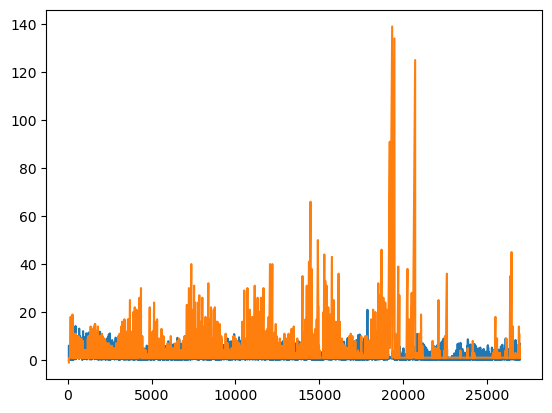

In [101]:
# plt.plot(df_ventral_fin['VTP1_x'])
plt.plot(df_ventral_speeds['speed_VTP1'])
plt.plot(df_test_ind_diff)

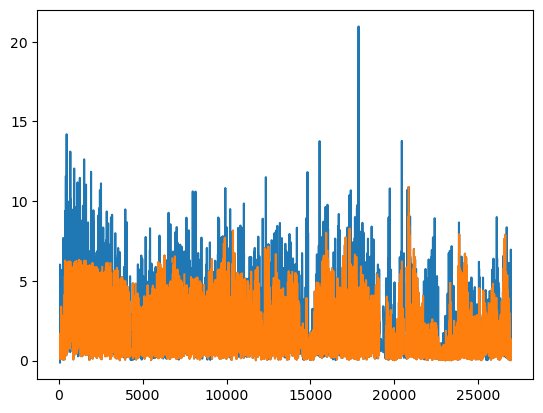

In [96]:
# plt.plot(df_ventral_fin['VTP1_x'])
plt.plot(df_ventral_speeds['speed_VTP1'])
# plt.plot(df_test_ind_diff)
plt.plot(df_ventral_speeds_filt['speed_VTP1'])

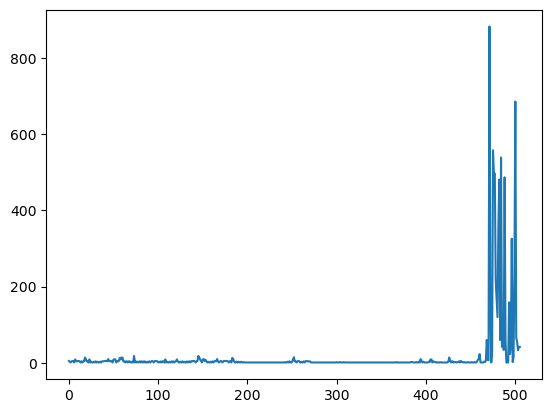

In [51]:
plt.plot(np.diff(df_ventral_speeds.index))

## MOUTH : Asymmetry

In [404]:
df_mouth = df_data[['MOUTH_x', 'MOUTH_y']].notna().mean(axis=1)
df_mouth.shape

(26793,)

In [405]:
df_mouth.loc[df_fin.index]

0        0.0
1        1.0
2        0.0
3        1.0
4        1.0
        ... 
26788    0.0
26789    0.0
26790    0.0
26791    1.0
26792    0.0
Length: 26792, dtype: float64

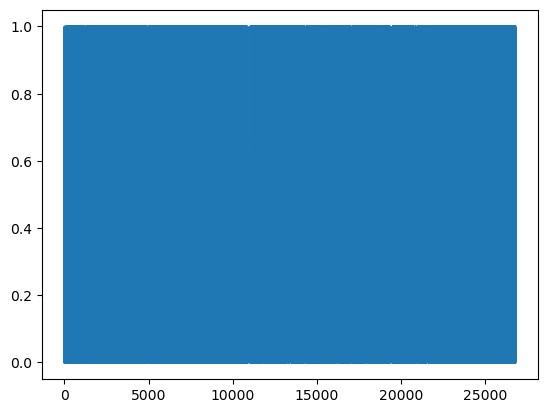

In [406]:
plt.plot(df_mouth)

In [407]:
df_mouth.sum()

12493.0

In [408]:
df_ventral_fin.shape

(12415, 22)

# Temp

In [161]:
col_dict = {col: i for i, col in enumerate(dlc_obj_test.df_data.columns)}
col_dict_rev = {v:k for k,v in col_dict.items()}

In [162]:
df_data_temp = dlc_obj_test.df_data
df_dorsal = df_data_temp.filter(regex='^(NT_|TT_|D).*(x|y)$')

In [163]:
df_dorsal_filt = df_dorsal[df_dorsal.isna().sum(axis=1) < 15]

In [164]:
df_dorsal_x = df_dorsal_filt.filter(like='_x')
df_dorsal_y = df_dorsal_filt.filter(like='_y')

In [165]:
df_dorsal_x_interpx = df_dorsal_x.rename(columns=col_dict).interpolate(axis=1, method='cubicspline', limit=5).rename(columns=col_dict_rev)
df_dorsal_x_interpy = df_dorsal_y.rename(columns=col_dict).interpolate(axis=1, method='cubicspline', limit=5).rename(columns=col_dict_rev)

In [166]:
df_ventral = df_data_temp.filter(regex='^V.*(x|y)$')
df_ventral_filt = df_ventral[df_ventral.isna().sum(axis=1) < 11]
df_ventral_x = df_ventral_filt.filter(like='_x')
df_ventral_y = df_ventral_filt.filter(like='_y')

In [167]:
df_ventral_x_interpx = df_ventral_x.rename(columns=col_dict).interpolate(axis=1, method='cubicspline', limit=5).rename(columns=col_dict_rev)
df_ventral_x_interpy = df_ventral_y.rename(columns=col_dict).interpolate(axis=1, method='cubicspline', limit=5).rename(columns=col_dict_rev)

In [168]:
df_dorsal_x_interpx.interpolate(limit=5, limit_direction='both').isna().sum()

NT_x       0
DH1_x      0
DH2_x      0
DNP_x      0
DTP1_x     0
DTP2_x     0
DTP3_x     0
DTP4_x     0
DTP5_x     0
DTP6_x     0
DTP7_x     0
DTP8_x     0
DTP9_x     0
DTP10_x    0
TT_x       0
dtype: int64

In [169]:
df_ventral_x_interpx.interpolate(limit=5, limit_direction='both').isna().sum()

VTP10_x    4
VTP9_x     0
VTP8_x     0
VTP7_x     0
VTP6_x     0
VTP5_x     0
VTP4_x     0
VTP3_x     0
VTP2_x     0
VTP1_x     0
VNP_x      0
dtype: int64

# Feature Extraction

In [218]:
class FeatureExtractor:

    def __init__(self, df_DLC):
        self.dlc_data = df_DLC
    
    def get_curvatures(self, dorsal=True):
        # how to approach NaN or missing values
                    
        return df_curv

    def get_speeds(self, all=True):
        # how to approach NaN or missing values
        # apply hampel filter to remove outliers
        return df_speeds

    def get_eccentricity(self, df_dorsal):
        # dorsal_xy is of the shape [number of frames x number of dorsal points x dim 2]
        dorsal_xy = df_dorsal.values.reshape(-1, 15, 2)
        # calculate quirkiness
        

    def get_length(self, nose_to_tail=True):
        # how to approach NaN or missing values
        return df_length

    def get_dist_from_centre(self, df_centre):
        return df_dist

    def get_mouth_visible(self):
        return df_mouth
    